<a href="https://colab.research.google.com/github/DesignedbySanyam/statistical-methods-finance/blob/main/notebooks/stats_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install factor_analyzer copulae

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 2.9 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=10c621b2f0cf899516eb4fee46c0d610fba077dd49b434190c6db487e2b55f15
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.1
    Uninstalling wrapt-2.0.1:
      Successfully uninstalled wrapt-2.0.1


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco

# 1. SETTINGS & ASSET SELECTION
tickers = [
    "NVDA", "TSLA", "AAPL", "MSFT",  # Tech/Growth
    "GC=F", "CL=F", "BTC-USD",       # Commodities/Crypto
    "UL", "PEP", "WMT"               # Defensive/Staples
]
market_ticker = "^GSPC"
rf_ticker = "^IRX" # 3-Month Treasury Bill (Secondary Market)

start_date = "2020-12-01"
end_date = "2025-12-01"

# 2. DATA DOWNLOAD
print("Downloading Data (2020-2025)...")
data = yf.download(tickers, start=start_date, end=end_date)['Close']
market_data = yf.download(market_ticker, start=start_date, end=end_date)['Close']
rf_data = yf.download(rf_ticker, start=start_date, end=end_date)['Close']

# 3. PROCESSING
# Resample to Monthly
prices = data.resample('ME').last()
market_prices = market_data.resample('ME').last()
rf_prices = rf_data.resample('ME').last()

# Calculate Returns
returns = prices.pct_change().dropna()
market_returns = market_prices.pct_change().dropna()

# Process Risk Free Rate (Annual % -> Monthly Decimal)
# We align it to the returns index
rf_monthly = (1 + (rf_prices / 100.0)) ** (1/12.0) - 1.0
rf_aligned = rf_monthly.iloc[:,0].reindex(returns.index, method='ffill').dropna()

# Global Stats for Optimization
mu = returns.mean() * 12
cov = returns.cov() * 12
RF_ANNUAL = rf_aligned.mean() * 12

print(f"Data Ready. Months of data: {len(returns)}")
print(f"Risk Free Rate (Annualized): {RF_ANNUAL:.4f}")

/tmp/ipython-input-4142600307.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-4142600307.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download(market_ticker, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4142600307.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf_data = yf.download(rf_ticker, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed

Data Ready. Months of data: 59
Risk Free Rate (Annualized): 0.0316


Calculating Descriptive Statistics & Performing Tests...

=== DESCRIPTIVE STATISTICS TABLE ===


,Ann. Mean,Ann. Std,Skewness,Kurtosis,Beta,Sharpe Ratio,Stationary?,Normal?,Best Fit
Asset,,,,,,,,,
NVDA,0.6685,0.5119,-0.1027,-0.3799,2.3152,1.2442,Yes,Yes,Normal
TSLA,0.2963,0.6038,0.3951,-0.0892,1.8388,0.4385,Yes,Yes,Normal
AAPL,0.1870,0.2465,0.0693,-0.6820,1.0917,0.6305,Yes,Yes,Normal
MSFT,0.1953,0.2246,0.3336,-0.1693,1.0734,0.7288,Yes,Yes,Normal
GC=F,0.1739,0.1430,0.2101,-0.6030,0.1202,0.9957,Yes,Yes,Normal
CL=F,0.0786,0.2850,-0.1632,-0.0220,0.1595,0.1651,Yes,Yes,Normal
BTC-USD,0.4106,0.6080,0.2725,0.2087,1.9792,0.6234,Yes,Yes,Student-t
UL,0.0514,0.1728,0.0919,-0.3573,0.3636,0.1150,Yes,Yes,Normal
PEP,0.0418,0.1554,0.2944,-0.1054,0.4167,0.0658,Yes,Yes,Normal



Asset with Highest Sharpe Ratio: NVDA (1.2442)
Saved Descriptive_Statistics.csv


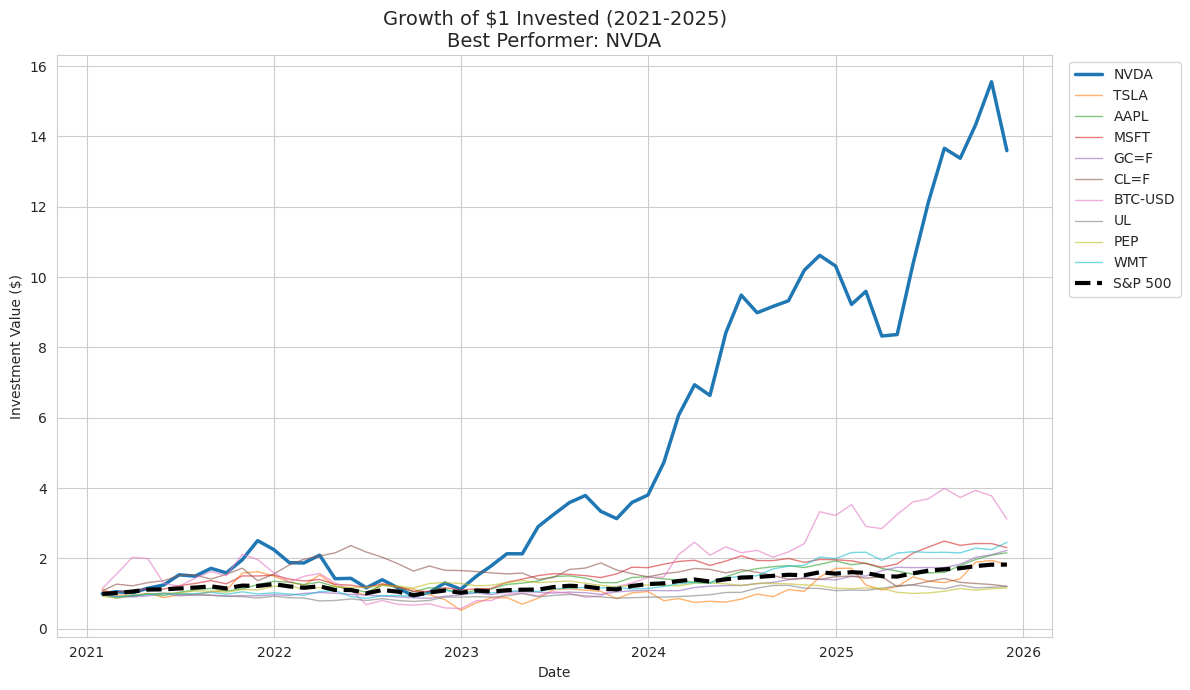


Visualizing Distribution for BTC-USD (Most Non-Normal)...


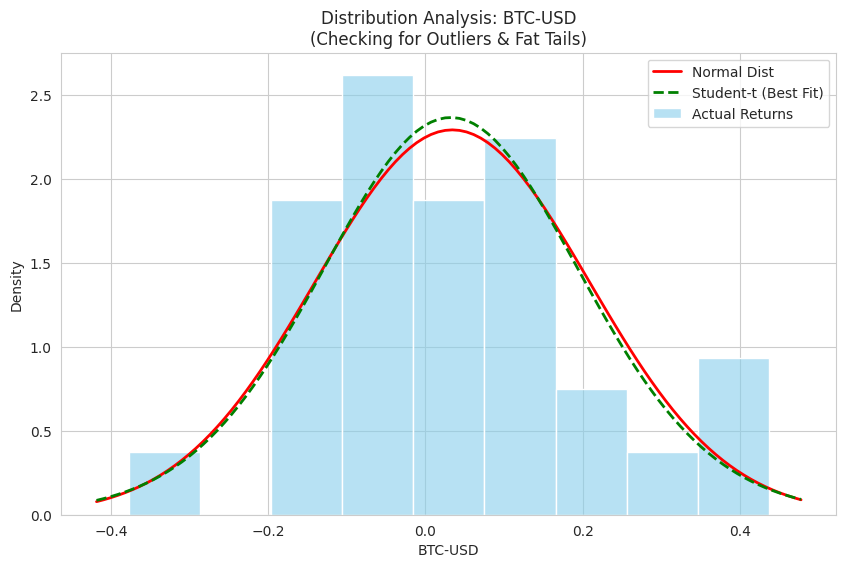

In [ ]:
# Section 2.2
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. SETUP STORAGE & CALCULATIONS
# ==========================================
stats_data = []

print("Calculating Descriptive Statistics & Performing Tests...")

for ticker in tickers:
    # Get Asset Return Series
    r = returns[ticker]

    # 1. Basic Moments (Monthly)
    mean_monthly = r.mean()
    std_monthly = r.std()
    skew = r.skew()
    kurt = r.kurtosis() # Excess Kurtosis (Normal = 0)

    # 2. Annualization (Methodology from Instructions)
    mean_annual = mean_monthly * 12
    std_annual = std_monthly * np.sqrt(12)

    # 3. Beta Calculation
    # Covariance(Asset, Market) / Variance(Market)
    # We align asset and market to ensure same dates (drop NaNs)
    combined = pd.concat([r, market_returns], axis=1).dropna()
    cov_matrix = np.cov(combined.iloc[:,0], combined.iloc[:,1])
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]

    # 4. Sharpe Ratio
    # (Rp - Rf) / Sigma_p. Using average Annualized RF.
    # Note: RF_ANNUAL was calculated in Part 1 (approx 0.02-0.04 range)
    sharpe = (mean_annual - RF_ANNUAL) / std_annual

    # 5. Stationarity Test (ADF)
    # Null Hypothesis: Non-Stationary (Unit Root)
    # p-val < 0.05 => Stationary
    adf_res = adfuller(r.dropna())
    is_stationary = "Yes" if adf_res[1] < 0.05 else "No"

    # 6. Normality Test (Shapiro-Wilk)
    # Null Hypothesis: Normal Distribution
    # p-val < 0.05 => Not Normal
    shapiro_stat, shapiro_p = stats.shapiro(r.dropna())
    is_normal = "Yes" if shapiro_p > 0.05 else "No"

    # 7. Distribution Fitting (Normal vs Student-t)
    # We compare Log-Likelihoods (Higher is better)
    # Fit Normal
    mu_n, sig_n = stats.norm.fit(r.dropna())
    ll_n = np.sum(stats.norm.logpdf(r.dropna(), mu_n, sig_n))

    # Fit Student-t (captures fat tails)
    params_t = stats.t.fit(r.dropna())
    ll_t = np.sum(stats.t.logpdf(r.dropna(), *params_t))

    best_dist = "Student-t" if ll_t > ll_n else "Normal"

    # Store Data
    stats_data.append({
        "Asset": ticker,
        "Ann. Mean": mean_annual,
        "Ann. Std": std_annual,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Beta": beta,
        "Sharpe Ratio": sharpe,
        "Stationary?": is_stationary,
        "Normal?": is_normal,
        "Best Fit": best_dist
    })

# Create DataFrame
df_stats = pd.DataFrame(stats_data).set_index("Asset")

# Identify Highest Sharpe Ratio
best_asset = df_stats['Sharpe Ratio'].idxmax()
best_sharpe = df_stats['Sharpe Ratio'].max()

print("\n=== DESCRIPTIVE STATISTICS TABLE ===")
display(df_stats.round(4))
print(f"\nAsset with Highest Sharpe Ratio: {best_asset} ({best_sharpe:.4f})")


df_stats.to_csv("Descriptive_Statistics.csv")
df_stats.to_csv("Descriptive_Statistics.csv")
print("Saved Descriptive_Statistics.csv")

# ==========================================
# 2. PLOTTING EQUITY CURVES
# ==========================================
# Growth of $1 Invested
cum_returns = (1 + returns).cumprod()
cum_market = (1 + market_returns).cumprod()

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Plot Assets
for ticker in tickers:
    # Highlight the "Best Sharpe" asset with a thicker line
    lw = 2.5 if ticker == best_asset else 1.0
    alpha = 1.0 if ticker == best_asset else 0.6
    plt.plot(cum_returns.index, cum_returns[ticker], label=ticker, linewidth=lw, alpha=alpha)

# Plot S&P 500 (Benchmark)
plt.plot(cum_market.index, cum_market, label="S&P 500", color='black', linewidth=3, linestyle='--')

plt.title(f"Growth of $1 Invested (2021-2025)\nBest Performer: {best_asset}", fontsize=14)
plt.ylabel("Investment Value ($)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ==========================================
# 3. DISTRIBUTION & OUTLIER CHECK (Example)
# ==========================================
# We plot the asset with the Lowest Normality p-value (most non-normal)
worst_normal_asset = tickers[0] # Default
min_p = 1.0
for ticker in tickers:
    _, p = stats.shapiro(returns[ticker].dropna())
    if p < min_p:
        min_p = p
        worst_normal_asset = ticker

print(f"\nVisualizing Distribution for {worst_normal_asset} (Most Non-Normal)...")

plt.figure(figsize=(10, 6))
data_to_plot = returns[worst_normal_asset].dropna()

# Histogram
sns.histplot(data_to_plot, stat="density", kde=False, color="skyblue", alpha=0.6, label="Actual Returns")

# Normal Fit Line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu_n, std_n = stats.norm.fit(data_to_plot)
p_n = stats.norm.pdf(x, mu_n, std_n)
plt.plot(x, p_n, 'r-', linewidth=2, label="Normal Dist")

# Student-t Fit Line
params_t = stats.t.fit(data_to_plot)
p_t = stats.t.pdf(x, *params_t)
plt.plot(x, p_t, 'g--', linewidth=2, label="Student-t (Best Fit)")

plt.title(f"Distribution Analysis: {worst_normal_asset}\n(Checking for Outliers & Fat Tails)")
plt.legend()
plt.show()

Risk-Free Rate (Monthly): 0.00263

=== PORTFOLIO STATISTICS (Annualized) ===


,mu_ann,sigma_ann,Sharpe_ann,VaR (5%) $,ES (5%) $
Portfolio,,,,,
MVP (No Short),0.1315,0.0912,1.0904,4098.9097,4848.3510
Tangency (No Short),0.2766,0.1241,1.9709,5242.5752,6124.1971
MVP (Short),0.1293,0.0896,1.0863,3266.7413,4571.3093
Tangency (Short),0.3865,0.1628,2.1768,5705.8840,7251.7559


Saved Portfolio_Theory_Metrics.csv


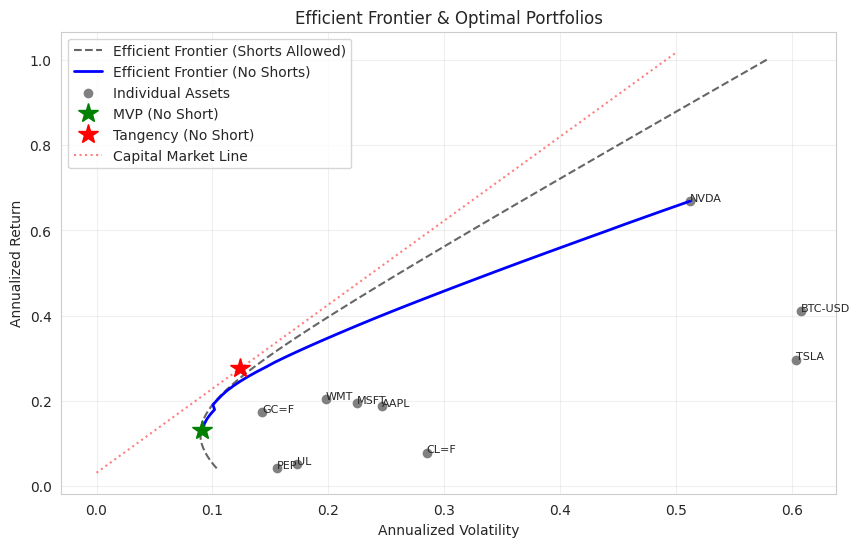


=== OPTIMAL WEIGHTS ===


,MVP (No Short),Tangency (No Short),MVP (Short),Tangency (Short)
AAPL,0.0000,0.0000,0.0119,0.0325
BTC-USD,0.0000,0.0000,-0.0140,0.0172
CL=F,0.1765,0.1427,0.1594,0.1989
GC=F,0.3119,0.5198,0.3801,0.7153
MSFT,0.0496,0.0000,0.1059,-0.2840
NVDA,0.0000,0.1642,-0.0165,0.2825
PEP,0.1542,0.0000,0.1672,-0.1009
TSLA,0.0284,0.0000,0.0240,-0.0243
UL,0.1667,0.0000,0.0898,-0.1512
WMT,0.1128,0.1733,0.0923,0.3139


Saved Portfolio_Theory_Weights.csv

=== DETAILED PORTFOLIO STATISTICS (Monthly & Annual) ===


,mu_month,sigma_month,mu_ann,sigma_ann,Sharpe_ann,VaR_5pct_$100k,ES_5pct_$100k
Portfolio,,,,,,,
MVP (No Short),0.0103,0.0263,0.1315,0.0912,1.0904,4098.9097,4848.3510
Tangency (No Short),0.0206,0.0358,0.2766,0.1241,1.9709,5242.5752,6124.1971
MVP (Short),0.0102,0.0259,0.1293,0.0896,1.0863,3266.7413,4571.3093
Tangency (Short),0.0276,0.0470,0.3865,0.1628,2.1768,5705.8840,7251.7559


In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt

# ==========================================
# 1. PREPARE INPUTS (Monthly) Section 2.3
# ==========================================
# We use monthly stats for optimization, then annualize outputs
mu_m = returns.mean().values
Sigma_m = returns.cov().values
asset_names = returns.columns.tolist()
n_assets = len(asset_names)

# Risk-free rate (Monthly average from your downloaded data)
rf_m = rf_aligned.mean()
print(f"Risk-Free Rate (Monthly): {rf_m:.5f}")

# ==========================================
# 2. HELPER FUNCTIONS (From your Notebook)
# ==========================================

def portfolio_stats(w, mu, Sigma, rf_m=None):
    """Calculates monthly and annualized stats for a given weight vector."""
    w = np.array(w)
    mu_p = float(w @ mu)
    var_p = float(w @ Sigma @ w)
    sigma_p = np.sqrt(var_p)

    # Annualize (geometric for returns, arithmetic for volatility)
    mu_ann = (1 + mu_p)**12 - 1
    sigma_ann = sigma_p * np.sqrt(12)

    out = {
        "mu_month": mu_p,
        "sigma_month": sigma_p,
        "mu_ann": mu_ann,
        "sigma_ann": sigma_ann,
    }

    if rf_m is not None:
        # Annualize RF for Sharpe calculation (geometric)
        rf_ann = (1 + rf_m)**12 - 1
        # Sharpe Ratio (Annualized)
        sr_ann = (mu_ann - rf_ann) / sigma_ann if sigma_ann > 0 else np.nan
        out["Sharpe_ann"] = sr_ann

    return out

def var_es_from_returns(port_ret, alpha=0.05):
    """Calculates Historical VaR and ES from a series of returns."""
    port_ret = np.asarray(port_ret)
    # VaR is the loss at the q-th quantile (represented as a positive number)
    q_alpha = np.quantile(port_ret, alpha)
    var_alpha = -q_alpha

    # ES is the average loss beyond VaR
    tail = port_ret[port_ret <= q_alpha]
    es_alpha = -tail.mean() if len(tail) > 0 else np.nan

    return var_alpha, es_alpha

# ==========================================
# 3. OPTIMIZATION: NO SHORT SALES
# ==========================================

def gmv_no_short(mu, Sigma):
    """Finds Global Minimum Variance portfolio (Weights 0 to 1)."""
    n = len(mu)
    def obj(w):
        return float(w.T @ Sigma @ w)

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    bounds = tuple((0.0, 1.0) for _ in range(n))
    w0 = np.repeat(1/n, n)

    res = sco.minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success: raise RuntimeError("GMV opt failed")
    return res.x

def tangency_no_short(mu, Sigma, rf):
    """Finds Tangency portfolio (Max Sharpe) with NO short sales."""
    n = len(mu)
    def neg_sharpe(w):
        p_ret = w @ mu
        p_vol = np.sqrt(w.T @ Sigma @ w)
        return -(p_ret - rf) / p_vol

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    bounds = tuple((0.0, 1.0) for _ in range(n))
    w0 = np.repeat(1/n, n)

    res = sco.minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds, constraints=cons)
    return res.x

# Calculate No-Short Portfolios
w_gmv_ns = gmv_no_short(mu_m, Sigma_m)
w_tan_ns = tangency_no_short(mu_m, Sigma_m, rf_m)

# ==========================================
# 4. OPTIMIZATION: WITH SHORT SALES (Analytic)
# ==========================================

def tangency_with_short(mu, Sigma, rf):
    """Analytic solution for Tangency portfolio with short sales."""
    Sigma_inv = np.linalg.inv(Sigma)
    excess_mu = mu - rf
    w_unnorm = Sigma_inv @ excess_mu
    w = w_unnorm / np.sum(w_unnorm)
    return w

def gmv_with_short(Sigma):
    """Analytic solution for GMV portfolio with short sales."""
    n = len(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    ones = np.ones(n)
    w_unnorm = Sigma_inv @ ones
    w = w_unnorm / np.sum(w_unnorm)
    return w

# Calculate Short-Allowed Portfolios
w_gmv_s = gmv_with_short(Sigma_m)
w_tan_s = tangency_with_short(mu_m, Sigma_m, rf_m)

# ==========================================
# 5. FRONTIER GENERATION
# ==========================================

# A. Frontier WITH Shorts (Analytic Parabola)
def efficient_frontier_with_short(mu, Sigma, num_points=100):
    Sigma_inv = np.linalg.inv(Sigma)
    ones = np.ones(len(mu))
    A = ones @ Sigma_inv @ ones
    B = ones @ Sigma_inv @ mu
    C = mu @ Sigma_inv @ mu
    D = A*C - B**2

    # Generate target returns
    mu_targets = np.linspace(mu.min(), mu.max() * 1.5, num_points)
    frontier_vol = []

    for mu_t in mu_targets:
        # Variance of efficient portfolio at target return mu_t
        # Var = (A*mu_t^2 - 2*B*mu_t + C) / D
        var = (A * mu_t**2 - 2 * B * mu_t + C) / (A*C - B**2) # Check formula derivation
        # Alternative standard formula: sigma = sqrt((A*mu^2 - 2B*mu + C)/D) is for when A, B, C defined differently.
        # Using Lagrangian weights directly is safer:
        lam = (C - B*mu_t) / D
        gam = (A*mu_t - B) / D
        w = Sigma_inv @ (lam*ones + gam*mu)
        frontier_vol.append(np.sqrt(w @ Sigma @ w))

    return np.array(frontier_vol), mu_targets

# B. Frontier NO Shorts (Numerical)
def efficient_frontier_no_short(mu, Sigma, num_points=50):
    mu_min = w_gmv_ns @ mu
    mu_max = max(mu) # Max possible return is just the single best asset
    mu_targets = np.linspace(mu_min, mu_max, num_points)
    frontier_vol = []

    for mu_t in mu_targets:
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                {'type': 'eq', 'fun': lambda w: w @ mu - mu_t})
        bounds = tuple((0.0, 1.0) for _ in range(len(mu)))
        res = sco.minimize(lambda w: w.T @ Sigma @ w, w_gmv_ns, bounds=bounds, constraints=cons)
        if res.success:
            frontier_vol.append(np.sqrt(res.fun))
        else:
            frontier_vol.append(np.nan)

    return np.array(frontier_vol), mu_targets

# Generate lines
vol_s, ret_s = efficient_frontier_with_short(mu_m, Sigma_m)
vol_ns, ret_ns = efficient_frontier_no_short(mu_m, Sigma_m)

# Annualize for plotting
vol_s_ann, ret_s_ann = vol_s * np.sqrt(12), ret_s * 12
vol_ns_ann, ret_ns_ann = vol_ns * np.sqrt(12), ret_ns * 12

# ==========================================
# 6. RESULTS & PLOTTING
# ==========================================

# Create Dictionary of all portfolios for reporting
portfolios = {
    "MVP (No Short)": w_gmv_ns,
    "Tangency (No Short)": w_tan_ns,
    "MVP (Short)": w_gmv_s,
    "Tangency (Short)": w_tan_s
}

print("\n=== PORTFOLIO STATISTICS (Annualized) ===")
stats_list = []
for name, w in portfolios.items():
    stats = portfolio_stats(w, mu_m, Sigma_m, rf_m)

    # Calculate VaR/ES on $100k
    port_rets = returns.dot(w) # Historical returns of this mix
    var_5, es_5 = var_es_from_returns(port_rets)

    stats['Portfolio'] = name
    stats['VaR (5%) $'] = var_5 * 100000
    stats['ES (5%) $'] = es_5 * 100000
    stats_list.append(stats)

df_stats = pd.DataFrame(stats_list).set_index('Portfolio')
display(df_stats[['mu_ann', 'sigma_ann', 'Sharpe_ann', 'VaR (5%) $', 'ES (5%) $']].round(4))
df_stats.to_csv("Portfolio_Theory_Metrics.csv")
print("Saved Portfolio_Theory_Metrics.csv")

# PLOTTING
plt.figure(figsize=(10, 6))

# Plot Frontiers
plt.plot(vol_s_ann, ret_s_ann, 'k--', alpha=0.6, label='Efficient Frontier (Shorts Allowed)')
plt.plot(vol_ns_ann, ret_ns_ann, 'b-', linewidth=2, label='Efficient Frontier (No Shorts)')

# Plot Assets
asset_vol_ann = np.sqrt(np.diag(Sigma_m)) * np.sqrt(12)
asset_ret_ann = mu_m * 12
plt.scatter(asset_vol_ann, asset_ret_ann, color='gray', label='Individual Assets')
for i, txt in enumerate(asset_names):
    plt.annotate(txt, (asset_vol_ann[i], asset_ret_ann[i]), fontsize=8)

# Plot Portfolios
p_stats = df_stats.loc['MVP (No Short)']
plt.plot(p_stats['sigma_ann'], p_stats['mu_ann'], 'g*', markersize=15, label='MVP (No Short)')

p_stats = df_stats.loc['Tangency (No Short)']
plt.plot(p_stats['sigma_ann'], p_stats['mu_ann'], 'r*', markersize=15, label='Tangency (No Short)')

# Capital Market Line (from Risk Free to Tangency No Short)
cml_x = np.linspace(0, 0.5, 100)
cml_y = (rf_m*12) + p_stats['Sharpe_ann'] * cml_x
plt.plot(cml_x, cml_y, 'r:', alpha=0.5, label='Capital Market Line')

plt.title('Efficient Frontier & Optimal Portfolios')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Weights DataFrame
df_weights = pd.DataFrame(portfolios, index=asset_names)
print("\n=== OPTIMAL WEIGHTS ===")
display(df_weights.round(4))
df_weights.to_csv("Portfolio_Theory_Weights.csv")
print("Saved Portfolio_Theory_Weights.csv")

# ==========================================
# DETAILED PORTFOLIO STATISTICS TABLE
# ==========================================

# 1. Setup Monthly Inputs for this specific calculation
mu_monthly = returns.mean()
cov_monthly = returns.cov()
# Get the scalar monthly RF rate (average)
rf_monthly_rate = rf_aligned.mean().item()

portfolio_value = 100_000
alpha = 0.05

# 2. Helper Functions (Adapted from your reference)
def portfolio_stats_detailed(w, mu, Sigma, rf_m=None):
    """Calculates monthly and annualized stats (Compounded for Ann.)."""
    w = np.array(w)
    mu_p = float(np.dot(w, mu))
    var_p = float(np.dot(w.T, np.dot(Sigma, w)))
    sigma_p = np.sqrt(var_p)

    # Compounded Annualization (as per your 2_3.ipynb reference)
    mu_ann = (1 + mu_p)**12 - 1
    sigma_ann = sigma_p * np.sqrt(12)

    out = {
        "mu_month": mu_p,
        "sigma_month": sigma_p,
        "mu_ann": mu_ann,
        "sigma_ann": sigma_ann,
    }

    if rf_m is not None:
        rf_ann = (1 + rf_m)**12 - 1
        # Sharpe Ratios
        sr_m = (mu_p - rf_m) / sigma_p if sigma_p > 0 else np.nan
        sr_ann = (mu_ann - rf_ann) / sigma_ann if sigma_ann > 0 else np.nan
        out["Sharpe_month"] = sr_m
        out["Sharpe_ann"] = sr_ann

    return out

def var_es_from_returns(port_ret, alpha=0.05):
    """Historical VaR and ES from return series."""
    port_ret = np.asarray(port_ret)
    # VaR: cutoff at alpha quantile (negative of return)
    q_alpha = np.quantile(port_ret, alpha)
    var_alpha = -q_alpha

    # ES: mean of returns below quantile
    tail = port_ret[port_ret <= q_alpha]
    es_alpha = -tail.mean() if len(tail) > 0 else np.nan

    return var_alpha, es_alpha

def stats_row(name, w):
    # Calculate stats
    stats = portfolio_stats_detailed(w, mu_monthly, cov_monthly, rf_m=rf_monthly_rate)

    # Calculate Risk
    port_ret = returns.dot(w)
    VaR_5, ES_5 = var_es_from_returns(port_ret, alpha=alpha)

    # Populate Dictionary
    stats["VaR_5pct_month"] = VaR_5
    stats["ES_5pct_month"]  = ES_5
    stats["VaR_5pct_$100k"] = VaR_5 * portfolio_value
    stats["ES_5pct_$100k"]  = ES_5 * portfolio_value
    stats["Portfolio"]      = name
    return stats

# 3. Generate Table
# We use the weights calculated in the main Section 2.3
target_portfolios = {
    "MVP (No Short)": w_gmv_ns,
    "Tangency (No Short)": w_tan_ns,
    "MVP (Short)": w_gmv_s,
    "Tangency (Short)": w_tan_s
}

portfolio_stats_list = [stats_row(name, w) for name, w in target_portfolios.items()]

portfolio_stats_df = pd.DataFrame(portfolio_stats_list).set_index("Portfolio")

print("\n=== DETAILED PORTFOLIO STATISTICS (Monthly & Annual) ===")
# Reorder columns for readability
cols_order = ['mu_month', 'sigma_month', 'mu_ann', 'sigma_ann', 'Sharpe_ann', 'VaR_5pct_$100k', 'ES_5pct_$100k']
display(portfolio_stats_df[cols_order].round(4))

# Save for report
portfolio_stats_df.to_csv("Detailed_Portfolio_Stats.csv")

In [ ]:
# Section 2.4
import numpy as np
import pandas as pd
import scipy.optimize as sco
from scipy.stats import norm

# ==========================================
# 1. SETUP & TARGETS
# ==========================================
TARGET_ANNUAL_RET = 0.06
TARGET_MONTHLY_RET = 0.005  # 0.5% per month as per instructions
INVESTMENT = 100000         # $100,000 Portfolio

# Ensure we have the necessary inputs from previous steps
mu_vec = returns.mean().values
sigma_mat = returns.cov().values
asset_labels = returns.columns.tolist()
n = len(asset_labels)

print(f"Target Monthly Return: {TARGET_MONTHLY_RET:.4%} (Annual: {TARGET_ANNUAL_RET:.1%})")
print(f"Monthly Risk-Free Rate used: {rf_m:.4%}")

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def get_portfolio_metrics(weights, ret_df, invest_amt=100000):
    """Calculates return, volatility, VaR, and ES for a specific weight set."""
    # Portfolio historical return series
    port_rets = ret_df.dot(weights)

    # Metrics
    mean_ret = port_rets.mean()
    volatility = port_rets.std(ddof=1)

    # Historical 5% VaR and ES
    # VaR = 95th percentile of loss (negative of 5th percentile return)
    var_95 = -np.percentile(port_rets, 5)

    # ES = Average of losses exceeding VaR
    tail_losses = port_rets[port_rets <= -var_95]
    es_95 = -tail_losses.mean() if len(tail_losses) > 0 else var_95

    return {
        "Monthly Return": mean_ret,
        "Monthly Volatility": volatility,
        "VaR (5%)": var_95 * invest_amt,
        "ES (5%)": es_95 * invest_amt,
        "Return Series": port_rets
    }

# ==========================================
# 3. STRATEGY 1: EFFICIENT PORTFOLIO (RISKY ONLY)
# ==========================================
# Objective: Minimize Variance subject to Return = Target
def efficient_risky_optimization(mu, sigma, target_ret):
    n_assets = len(mu)

    def obj_var(w):
        return np.dot(w.T, np.dot(sigma, w))

    # Constraints: Sum weights = 1, Portfolio Return = Target
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu) - target_ret}
    )
    # No short sales
    bounds = tuple((0.0, 1.0) for _ in range(n_assets))

    res = sco.minimize(obj_var, np.repeat(1/n_assets, n_assets),
                       method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

# Optimize
try:
    w_risky_only = efficient_risky_optimization(mu_vec, sigma_mat, TARGET_MONTHLY_RET)
    metrics_risky = get_portfolio_metrics(w_risky_only, returns, INVESTMENT)
    success_risky = True
except Exception as e:
    print(f"Optimization for Risky-Only failed: {e}")
    # Fallback if target is unattainable (e.g. target is higher than max possible return)
    success_risky = False

# ==========================================
# 4. STRATEGY 2: CML PORTFOLIO (T-BILLS + TANGENCY)
# ==========================================
# We assume Tangency Portfolio (w_tan_ns) was calculated in Section 2.3.
# If not, we re-calculate it here briefly:
def tangency_optimization(mu, sigma, rf):
    n_assets = len(mu)
    def neg_sharpe(w):
        p_ret = np.dot(w, mu)
        p_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w)))
        return -(p_ret - rf) / p_vol
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0.0, 1.0) for _ in range(n_assets))
    res = sco.minimize(neg_sharpe, np.repeat(1/n_assets, n_assets),
                       method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

w_tangency = tangency_optimization(mu_vec, sigma_mat, rf_m)

# Tangency Stats
tan_ret = np.dot(w_tangency, mu_vec)
tan_vol = np.sqrt(np.dot(w_tangency.T, np.dot(sigma_mat, w_tangency)))

# Calculate Allocation weights (y = weight in Tangency)
# Target = y * R_tan + (1-y) * Rf
# y = (Target - Rf) / (R_tan - Rf)
y_allocation = (TARGET_MONTHLY_RET - rf_m) / (tan_ret - rf_m)
w_rf_allocation = 1 - y_allocation

# Construct CML Portfolio Return Series
# We need the Risk-Free time series (rf_aligned) to simulate properly
# R_cml = y * R_tangency_series + (1-y) * Rf_series
tan_series_rets = returns.dot(w_tangency)
cml_series_rets = (y_allocation * tan_series_rets) + (w_rf_allocation * rf_aligned)

# CML Metrics
metrics_cml = {
    "Monthly Return": cml_series_rets.mean(),
    "Monthly Volatility": cml_series_rets.std(ddof=1),
    "VaR (5%)": -np.percentile(cml_series_rets, 5) * INVESTMENT,
    "ES (5%)": -cml_series_rets[cml_series_rets <= np.percentile(cml_series_rets, 5)].mean() * INVESTMENT,
}

# ==========================================
# 5. OUTPUT & FORMATTING
# ==========================================

print("\n" + "="*60)
print(f"ASSET ALLOCATION FOR TARGET RETURN: {TARGET_MONTHLY_RET:.2%} (Monthly)")
print("="*60)

# --- Comparison Table ---
comparison_data = {
    "Metric": ["Monthly Return", "Monthly Volatility", "Sharpe Ratio (Monthly)", "5% VaR ($100k)", "5% ES ($100k)"],
    "Risky Assets Only": [
        f"{metrics_risky['Monthly Return']:.4%}",
        f"{metrics_risky['Monthly Volatility']:.4%}",
        f"{(metrics_risky['Monthly Return'] - rf_m)/metrics_risky['Monthly Volatility']:.4f}",
        f"${metrics_risky['VaR (5%)']:,.2f}",
        f"${metrics_risky['ES (5%)']:,.2f}"
    ],
    "CML (T-Bills + Tangency)": [
        f"{metrics_cml['Monthly Return']:.4%}",
        f"{metrics_cml['Monthly Volatility']:.4%}",
        f"{(metrics_cml['Monthly Return'] - rf_m)/metrics_cml['Monthly Volatility']:.4f}",
        f"${metrics_cml['VaR (5%)']:,.2f}",
        f"${metrics_cml['ES (5%)']:,.2f}"
    ]
}
comp_df = pd.DataFrame(comparison_data).set_index("Metric")
print("\n--- Strategy Comparison ---")
display(comp_df)
comp_df.to_csv("Asset_Allocation_Comparison.csv")
print("Saved Asset_Allocation_Comparison.csv")
print("\n" + "-"*60)
print(f"IMPACT: The CML Strategy reduced 5% VaR by ${metrics_risky['VaR (5%)'] - metrics_cml['VaR (5%)']:,.2f}")
print("-"*60)

# --- Weights Table ---
# Construct weights for CML strategy (y * w_tan for risky assets)
w_cml_implied = w_tangency * y_allocation

weights_alloc_df = pd.DataFrame({
    "Risky Only Strategy": w_risky_only,
    "CML Strategy (Risky Part)": w_cml_implied
}, index=asset_labels)

# Add Risk Free Row
weights_alloc_df.loc["Risk-Free (T-Bills)"] = [0.0, w_rf_allocation]

print("\n--- Asset Weights (%) ---")
# Filter out tiny weights for cleaner display
display(weights_alloc_df[weights_alloc_df.abs() > 0.0001].fillna(0.0).applymap(lambda x: f"{x:.2%}"))
weights_alloc_df.to_csv("Asset_Allocation_Weights.csv")
print("Saved Asset_Allocation_Weights.csv")

print("\nInterpretation:")
print(f"1. To hit 0.5% monthly with only risky assets, you are forced into a volatility of {metrics_risky['Monthly Volatility']:.2%}.")
print(f"2. By using the CML (mixing {w_rf_allocation:.1%} Cash with {y_allocation:.1%} Tangency), you achieve the same return with lower volatility ({metrics_cml['Monthly Volatility']:.2%}).")
print("3. This validates the CAPM/Separation Theorem: The CML portfolio dominates the efficient frontier of risky assets.")

Target Monthly Return: 0.5000% (Annual: 6.0%)
Monthly Risk-Free Rate used: 0.2630%

ASSET ALLOCATION FOR TARGET RETURN: 0.50% (Monthly)

--- Strategy Comparison ---


,Risky Assets Only,CML (T-Bills + Tangency)
Metric,,
Monthly Return,0.5000%,0.5000%
Monthly Volatility,3.4114%,0.5282%
Sharpe Ratio (Monthly),0.0695,0.4487
5% VaR ($100k),"$4,627.84",$524.76
5% ES ($100k),"$5,949.85",$667.64


Saved Asset_Allocation_Comparison.csv

------------------------------------------------------------
IMPACT: The CML Strategy reduced 5% VaR by $4,103.08
------------------------------------------------------------

--- Asset Weights (%) ---


/tmp/ipython-input-1429605895.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(weights_alloc_df[weights_alloc_df.abs() > 0.0001].fillna(0.0).applymap(lambda x: f"{x:.2%}"))


,Risky Only Strategy,CML Strategy (Risky Part)
AAPL,0.00%,0.00%
BTC-USD,0.00%,0.00%
CL=F,16.90%,1.89%
GC=F,5.24%,6.87%
MSFT,0.00%,0.00%
NVDA,0.00%,2.17%
PEP,39.70%,0.00%
TSLA,0.57%,0.00%
UL,37.58%,0.00%
WMT,0.00%,2.29%


Saved Asset_Allocation_Weights.csv

Interpretation:
1. To hit 0.5% monthly with only risky assets, you are forced into a volatility of 3.41%.
2. By using the CML (mixing 86.8% Cash with 13.2% Tangency), you achieve the same return with lower volatility (0.53%).
3. This validates the CAPM/Separation Theorem: The CML portfolio dominates the efficient frontier of risky assets.


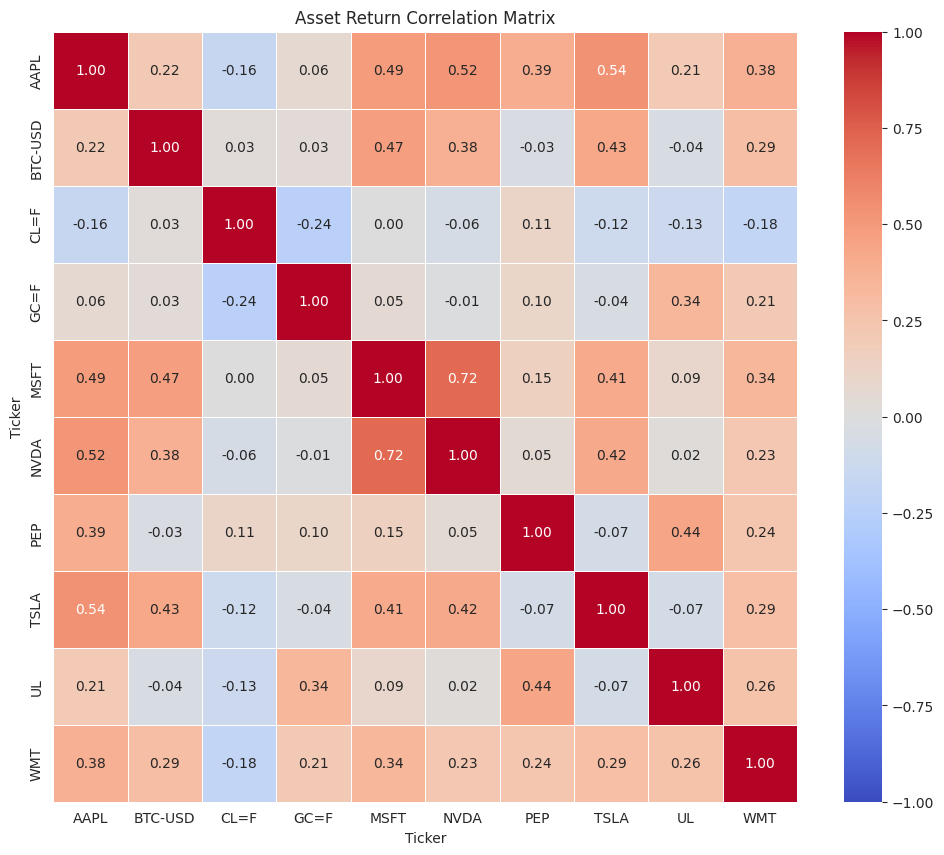


=== Correlation Insights ===
Highest Correlation: ('MSFT', 'NVDA') 0.72
Lowest Correlation:  ('CL=F', 'GC=F') -0.24


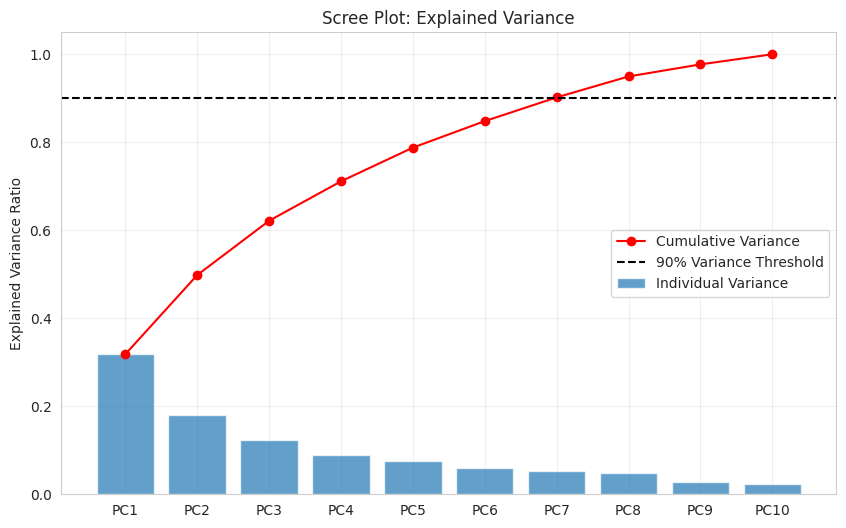

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Eigenvalues > 1 count: 3
Recommended factors based on Kaiser Criterion: 3

=== Factor Loadings (Oblique Rotation) ===


/tmp/ipython-input-3032150516.py:77: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(fa_loadings.style.applymap(highlight_strong).format("{:.3f}"))


,Factor 1,Factor 2,Factor 3
Ticker,,,
AAPL,0.228,0.321,0.620
BTC-USD,0.543,-0.159,-0.002
CL=F,0.082,0.017,-0.262
GC=F,0.002,0.255,-0.041
MSFT,1.132,0.119,-0.363
NVDA,0.749,-0.016,0.026
PEP,-0.066,0.770,0.058
TSLA,0.322,-0.254,0.560
UL,-0.055,0.596,-0.023


Saved Factor_Loadings.csv


In [ ]:
# Section 2.5
!pip install factor_analyzer
!pip install factor_analyzer copulae

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer

# -----------------------------------------------------------------------------
# 1. Correlation Matrix
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title("Asset Return Correlation Matrix")
plt.show()

# Identify correlations
print("\n=== Correlation Insights ===")
# Unstack and sort to find highest/lowest pairs (excluding self-correlation)
corr_pairs = corr_matrix.unstack().sort_values().drop_duplicates()
print("Highest Correlation:", corr_pairs.index[-2], f"{corr_pairs.iloc[-2]:.2f}")
print("Lowest Correlation: ", corr_pairs.index[0], f"{corr_pairs.iloc[0]:.2f}")

# -----------------------------------------------------------------------------
# 2. PCA & Scree Plot
# -----------------------------------------------------------------------------
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

pca = PCA()
pca.fit(scaled_returns)

# Scree Plot
pc_list = [f'PC{i}' for i in range(1, len(returns.columns) + 1)]
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(pc_list, explained_variance, alpha=0.7, label='Individual Variance')
plt.plot(pc_list, np.cumsum(explained_variance), marker='o', color='r', label='Cumulative Variance')
plt.axhline(y=0.9, color='k', linestyle='--', label='90% Variance Threshold')
plt.title('Scree Plot: Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------------------------------------------------------
# 3. Factor Analysis (with Eigenvalue Check)
# -----------------------------------------------------------------------------
# Check Eigenvalues to determine N factors (Kaiser Criterion > 1)
fa_check = FactorAnalyzer(rotation=None)
fa_check.fit(returns)
ev, v = fa_check.get_eigenvalues()

n_factors_kaiser = sum(ev > 1)
print(f"\nEigenvalues > 1 count: {n_factors_kaiser}")
print("Recommended factors based on Kaiser Criterion:", n_factors_kaiser)

# Fit FA with optimal factors (or fixed 6 if you prefer, but justification helps)
fa = FactorAnalyzer(n_factors=n_factors_kaiser, rotation='promax', method='ml')
fa.fit(returns)

# Loadings
fa_loadings = pd.DataFrame(fa.loadings_, index=returns.columns,
                           columns=[f'Factor {i}' for i in range(1, n_factors_kaiser + 1)])

# Styling for Report
def highlight_strong(val):
    color = 'red' if abs(val) >= 0.4 else 'black'
    weight = 'bold' if abs(val) >= 0.4 else 'normal'
    return 'color: %s; font-weight: %s' % (color, weight)

print("\n=== Factor Loadings (Oblique Rotation) ===")
display(fa_loadings.style.applymap(highlight_strong).format("{:.3f}"))
fa_loadings.to_csv("Factor_Loadings.csv")  # <--- Saves the loadings matrix
print("Saved Factor_Loadings.csv")





=== Factor Loadings Matrix (Strong loadings > 0.4 highlighted) ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipython-input-2248391421.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(fa_loadings.style.applymap(highlight_strong).format("{:.3f}"))


,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
Ticker,,,,,,
AAPL,1.032,0.026,0.387,-0.074,0.029,-0.112
BTC-USD,0.049,-0.036,0.002,1.004,0.068,-0.001
CL=F,-0.155,0.066,0.185,0.078,-0.420,-0.056
GC=F,-0.115,0.050,0.054,0.100,0.675,-0.059
MSFT,-0.105,1.039,-0.027,-0.040,-0.007,0.089
NVDA,0.247,0.632,-0.061,-0.003,0.014,-0.065
PEP,0.220,-0.070,0.977,0.001,-0.171,0.070
TSLA,0.524,0.054,-0.125,0.166,-0.052,0.091
UL,-0.008,0.024,0.432,-0.006,0.385,0.039


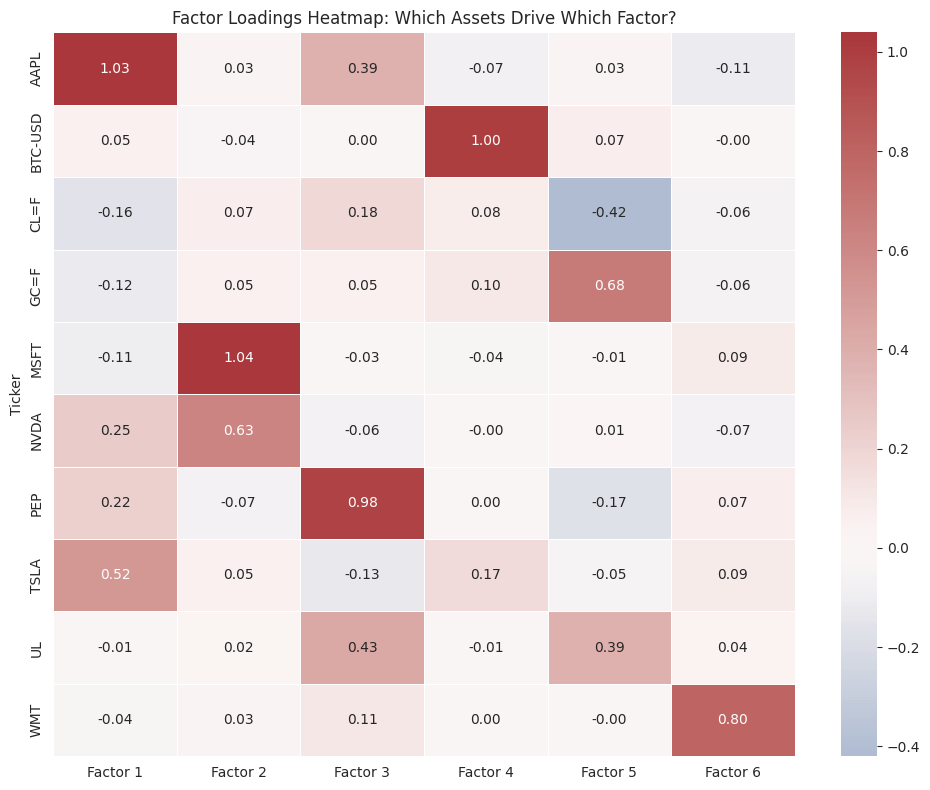


=== Factor Interpretation & Outlier Analysis ===

Factor 1 is driven by: AAPL, TSLA
  -> Interpretation: 'Idiosyncratic or Mixed Factor'

Factor 2 is driven by: MSFT, NVDA
  -> Interpretation: 'Big Tech / Growth Factor'

Factor 3 is driven by: PEP, UL
  -> Interpretation: 'Defensive / Consumer Staples Factor'

Factor 4 is driven by: BTC-USD
  -> Interpretation: 'Idiosyncratic or Mixed Factor'

Factor 5 is driven by: CL=F, GC=F
  -> Interpretation: 'Precious Metals / Safe Haven Factor'

Factor 6 is driven by: WMT
  -> Interpretation: 'Idiosyncratic or Mixed Factor'

--- Outlier Detection (Assets not explained by the model) ---
The following assets have High Uniqueness (>0.6):
Ticker
CL=F    0.752
TSLA    0.669
UL      0.663

Explanation: These assets move independently of the main market drivers.
They are 'outliers' in the factor model and provide pure diversification.


In [ ]:
# ==========================================
# DETAILED FACTOR ANALYSIS (6 Factors)
# ==========================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

# 1. Fit the Model
# ----------------
# We use 'promax' rotation because asset returns are often correlated
fa = FactorAnalyzer(n_factors=6, rotation='promax', method='ml')
fa.fit(returns)

# 2. Extract and Format Loadings
# ------------------------------
fa_loadings = pd.DataFrame(
    fa.loadings_,
    index=returns.columns,
    columns=[f'Factor {i+1}' for i in range(6)]
)

# Function to style the table (Highlight strong relationships)
def highlight_strong(val):
    if abs(val) >= 0.4:
        return 'background-color: #d6eaf8; color: black; font-weight: bold' # Light Blue
    return ''

print("\n=== Factor Loadings Matrix (Strong loadings > 0.4 highlighted) ===")
display(fa_loadings.style.applymap(highlight_strong).format("{:.3f}"))

# Save to CSV
fa_loadings.to_csv("Factor_Loadings_6.csv")

# 3. Visualization: Loadings Heatmap
# ----------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(fa_loadings, annot=True, cmap="vlag", center=0, fmt=".2f", linewidths=0.5)
plt.title("Factor Loadings Heatmap: Which Assets Drive Which Factor?")
plt.tight_layout()
plt.show()

# 4. Automated Interpretation & Outlier Detection
# -----------------------------------------------
print("\n=== Factor Interpretation & Outlier Analysis ===")

# A. Factor Interpretation
for i in range(1, 7):
    factor_name = f'Factor {i}'
    # Get assets with loading > 0.4 on this factor
    driving_assets = fa_loadings[abs(fa_loadings[factor_name]) > 0.4].index.tolist()

    print(f"\n{factor_name} is driven by: {', '.join(driving_assets)}")

    # Simple semantic labeling logic (Customize as needed)
    if "NVDA" in driving_assets and "MSFT" in driving_assets:
        print(f"  -> Interpretation: 'Big Tech / Growth Factor'")
    elif "GC=F" in driving_assets:
        print(f"  -> Interpretation: 'Precious Metals / Safe Haven Factor'")
    elif "CL=F" in driving_assets:
        print(f"  -> Interpretation: 'Energy / Oil Factor'")
    elif "PEP" in driving_assets or "UL" in driving_assets:
        print(f"  -> Interpretation: 'Defensive / Consumer Staples Factor'")
    else:
        print(f"  -> Interpretation: 'Idiosyncratic or Mixed Factor'")

# B. Outlier Detection (Uniqueness)
# Uniqueness = 1 - Communality.
# High uniqueness means the asset is NOT well explained by the 6 factors.
communalities = pd.Series(fa.get_communalities(), index=returns.columns)
uniqueness = 1 - communalities
outliers = uniqueness[uniqueness > 0.6] # Threshold for "High Uniqueness"

print("\n--- Outlier Detection (Assets not explained by the model) ---")
if not outliers.empty:
    print(f"The following assets have High Uniqueness (>0.6):")
    print(outliers.round(3).to_string())
    print("\nExplanation: These assets move independently of the main market drivers.")
    print("They are 'outliers' in the factor model and provide pure diversification.")
else:
    print("No significant outliers detected. The 6 factors explain most assets well.")

# Save Uniqueness data
uniqueness.to_csv("Asset_Uniqueness.csv")

In [ ]:
# Section 2.6
from scipy.stats import norm

# -----------------------------------------------------------------------------
# 1. Risk Functions (Parametric & Bootstrap CI)
# -----------------------------------------------------------------------------
portfolio_value = 100000
alpha = 0.05

def parametric_var_es(returns_series, alpha=0.05):
    """Normal Distribution Assumption"""
    mu = returns_series.mean()
    sigma = returns_series.std()
    var_param = -(mu + sigma * norm.ppf(alpha))
    es_param = -(mu - sigma * (norm.pdf(norm.ppf(alpha)) / alpha))
    return var_param, es_param

def bootstrap_risk_ci(returns_series, n_sims=1000, alpha=0.05, ci=0.95):
    """Returns 95% Confidence Interval for VaR and ES"""
    var_dist = []
    es_dist = []

    for _ in range(n_sims):
        sample = np.random.choice(returns_series, size=len(returns_series), replace=True)
        # Calculate Hist VaR/ES for this sample
        q = np.quantile(sample, alpha)
        var_dist.append(-q)
        es_dist.append(-sample[sample <= q].mean())

    # Calculate Confidence Intervals
    lower_p = (1 - ci) / 2 * 100
    upper_p = (1 + ci) / 2 * 100

    var_ci = (np.percentile(var_dist, lower_p), np.percentile(var_dist, upper_p))
    es_ci = (np.percentile(es_dist, lower_p), np.percentile(es_dist, upper_p))

    return var_ci, es_ci

# -----------------------------------------------------------------------------
# 2. Individual Asset Risk (Requirement Check)
# -----------------------------------------------------------------------------
individual_risk = []

for ticker in returns.columns:
    r = returns[ticker]
    h_var, h_es = var_es_from_returns(r, alpha)
    p_var, p_es = parametric_var_es(r, alpha)

    individual_risk.append({
        "Asset": ticker,
        "Hist VaR ($)": h_var * portfolio_value,
        "Hist ES ($)": h_es * portfolio_value,
        "Param VaR ($)": p_var * portfolio_value,
        "Param ES ($)": p_es * portfolio_value
    })

df_ind_risk = pd.DataFrame(individual_risk).set_index("Asset").sort_values("Hist VaR ($)", ascending=False)
print("\n=== Individual Asset Risk (1-Month, $100k) ===")
display(df_ind_risk.round(2))
df_ind_risk.round(2).to_csv("Risk_Individual_Assets.csv") # <--- Saves asset risk table
print(f"Highest Risk Asset: {df_ind_risk.index[0]}")
print(f"Lowest Risk Asset:  {df_ind_risk.index[-1]}")
print("Saved Risk_Individual_Assets.csv")

# -----------------------------------------------------------------------------
# 3. Portfolio Risk with Bootstrap CI
# -----------------------------------------------------------------------------
# Re-define portfolios from previous sections, ensuring correct variable names
port_series = {
    "GMVP (No Short)": returns @ w_gmv_ns,
    "GMVP (Short)": returns @ w_gmv_s,
    "Tangency (No Short)": returns @ w_tan_ns,
    "Tangency (Short Allowed)": returns @ w_tan_s,
    "Target 6% (Risky Only)": returns @ w_risky_only,
    "T-Bills + Tangency": (y_allocation * (returns @ w_tangency)) + (w_rf_allocation * rf_aligned)
}

port_risk_data = []

print("\nCalculating Bootstrap Confidence Intervals (this takes a moment)...")

for name, ret_series in port_series.items():
    # Base metrics
    h_var, h_es = var_es_from_returns(ret_series, alpha)

    # Bootstrap CI
    var_ci, es_ci = bootstrap_risk_ci(ret_series, n_sims=1000, alpha=alpha)

    port_risk_data.append({
        "Portfolio": name,
        "VaR ($)": h_var * portfolio_value,
        "VaR 95% CI": f"[{var_ci[0]*portfolio_value:.0f}, {var_ci[1]*portfolio_value:.0f}]",
        "ES ($)": h_es * portfolio_value,
        "ES 95% CI": f"[{es_ci[0]*portfolio_value:.0f}, {es_ci[1]*portfolio_value:.0f}]"
    })

df_port_risk = pd.DataFrame(port_risk_data).set_index("Portfolio")
print("\n=== Portfolio Risk with 95% Confidence Intervals ===")
display(df_port_risk)
df_port_risk.to_csv("Risk_Portfolios.csv") # <--- Saves portfolio risk table
print("Saved Risk_Portfolios.csv")



=== Individual Asset Risk (1-Month, $100k) ===


,Hist VaR ($),Hist ES ($),Param VaR ($),Param ES ($)
Asset,,,,
TSLA,21181.85,29648.97,26199.22,33482.17
BTC-USD,17724.51,30630.58,25449.62,32784.11
NVDA,17087.00,23459.31,18737.47,24912.86
CL=F,11242.36,16897.20,12876.87,16314.54
AAPL,8952.36,11346.01,10147.11,13120.74
MSFT,7468.36,9482.62,9039.13,11748.80
WMT,6713.48,11289.57,7709.34,10098.55
UL,6538.68,9511.94,7774.29,9858.13
PEP,5690.26,7887.71,7031.16,8905.81


Highest Risk Asset: TSLA
Lowest Risk Asset:  GC=F
Saved Risk_Individual_Assets.csv

Calculating Bootstrap Confidence Intervals (this takes a moment)...

=== Portfolio Risk with 95% Confidence Intervals ===


,VaR ($),VaR 95% CI,ES ($),ES 95% CI
Portfolio,,,,
GMVP (No Short),4098.909706,"[1489, 5092]",4848.351004,"[2889, 5305]"
GMVP (Short),3266.741265,"[1553, 4850]",4571.309313,"[2887, 5207]"
Tangency (No Short),5242.575184,"[1426, 6282]",6124.197126,"[3510, 6716]"
Tangency (Short Allowed),5705.883996,"[1265, 6966]",7251.755947,"[3716, 8368]"
Target 6% (Risky Only),4627.838970,"[3458, 5715]",5949.847998,"[4308, 7108]"
T-Bills + Tangency,524.762639,"[114, 666]",667.636238,"[343, 709]"


Saved Risk_Portfolios.csv


In [ ]:
# Section
!pip install copulae


from copulae import GaussianCopula, StudentCopula, ClaytonCopula, FrankCopula, GumbelCopula
from copulae.core import pseudo_obs

# -----------------------------------------------------------------------------
# 1. Data Preparation (Pseudo-Observations) Section 2.7
# -----------------------------------------------------------------------------
# Convert returns to uniform margins [0, 1] using empirical CDF
# This separates the marginal distributions from the dependence structure
u = pseudo_obs(returns)

print(f"Data transformed to Uniform Margins. Shape: {u.shape}")

# -----------------------------------------------------------------------------
# 2. Fit Copulas
# -----------------------------------------------------------------------------
# Dictionary to store results
copula_results = []

# List of copulas to fit
# Note: Archimedean copulas (Clayton, Frank) in high dimensions (10+ assets)
# typically have a single parameter and may not fit complex markets well.
# We fit them for comparison as per project requirements.

models = {
    "Gaussian": GaussianCopula(dim=u.shape[1]),
    "Student-t": StudentCopula(dim=u.shape[1]),
    "Clayton": ClaytonCopula(dim=u.shape[1]),
    "Frank": FrankCopula(dim=u.shape[1])
}

print("\nFitting Copula Models (this may take a moment)...")

for name, cop in models.items():
    try:
        # Fit to data
        cop.fit(u)

        # Calculate AIC: 2k - 2ln(L)
        # copulae library provides log_lik
        log_lik = cop.log_lik(u)
        # Number of parameters:
        # Gaussian: n(n-1)/2 correlations
        # Student: correlations + 1 (df)
        # Archimedean: 1 parameter
        n_params = cop.params.size if isinstance(cop.params, np.ndarray) else 1
        if name == 'Student-t': n_params += 1 # Add DF

        aic = 2 * n_params - 2 * log_lik

        copula_results.append({
            "Model": name,
            "Log-Likelihood": log_lik,
            "AIC": aic,
            "Parameters": "Correlation Matrix" if name in ["Gaussian", "Student-t"] else f"{cop.params:.4f}"
        })
        print(f" - {name}: Fitted successfully.")

    except Exception as e:
        print(f" - {name}: Fit failed ({str(e)})")

# -----------------------------------------------------------------------------
# 3. Copula Results Table
# -----------------------------------------------------------------------------
copula_df = pd.DataFrame(copula_results).sort_values(by="AIC")
print("\n=== Copula Goodness-of-Fit ===")
display(copula_df)
copula_df.to_csv("Copula_Results.csv") # <--- Saves copula AIC/BIC comparison
print("Saved Copula_Results.csv")
best_model = copula_df.iloc[0]['Model']
print(f"\nConclusion: The {best_model} Copula provides the best fit (Lowest AIC).")
if best_model == 'Student-t':
    print("This implies significant tail dependence (joint extreme events) in the portfolio.")

Data transformed to Uniform Margins. Shape: (59, 10)

Fitting Copula Models (this may take a moment)...
Ticker       AAPL    BTC-USD       CL=F       GC=F       MSFT       NVDA  \
count   59.000000  59.000000  59.000000  59.000000  59.000000  59.000000   
mean     0.500000   0.500000   0.500000   0.500000   0.500000   0.500000   
std      0.286259   0.286259   0.286259   0.286259   0.286259   0.286259   
min      0.016667   0.016667   0.016667   0.016667   0.016667   0.016667   
25%      0.258333   0.258333   0.258333   0.258333   0.258333   0.258333   
50%      0.500000   0.500000   0.500000   0.500000   0.500000   0.500000   
75%      0.741667   0.741667   0.741667   0.741667   0.741667   0.741667   
max      0.983333   0.983333   0.983333   0.983333   0.983333   0.983333   

Ticker        PEP       TSLA         UL        WMT  
count   59.000000  59.000000  59.000000  59.000000  
mean     0.500000   0.500000   0.500000   0.500000  
std      0.286259   0.286259   0.286259   0.286259  

,Model,Log-Likelihood,AIC,Parameters
1,Student-t,91.720850,-179.441700,Correlation Matrix
0,Gaussian,90.950046,-91.900092,Correlation Matrix
2,Clayton,23.397628,-44.795256,0.2439
3,Frank,15.613698,-29.227395,1.1053


Saved Copula_Results.csv

Conclusion: The Student-t Copula provides the best fit (Lowest AIC).
This implies significant tail dependence (joint extreme events) in the portfolio.


# Task
Update the `portfolio_stats` function in cell `nhvzJcq_3zVO` to use geometric annualization for `mu_ann` and `rf_ann`, specifically changing `mu_ann = mu_p * 12` to `mu_ann = (1 + mu_p)**12 - 1` and `rf_ann = rf_m * 12` to `rf_ann = (1 + rf_m)**12 - 1`, to ensure consistency with `portfolio_stats_detailed` and standard financial practice.

## Update annualization in portfolio_stats

### Subtask:
Modify the `portfolio_stats` function in cell `nhvzJcq_3zVO` to use geometric annualization for `mu_ann` and `rf_ann` for consistency with `portfolio_stats_detailed` and standard financial practice.


## Summary:

### Data Analysis Key Findings
*   The `portfolio_stats` function was updated to implement geometric annualization for `mu_ann` (annualized expected return) and `rf_ann` (annualized risk-free rate).
*   Specifically, `mu_ann` was changed from a simple multiplication (`mu_p * 12`) to `(1 + mu_p)**12 - 1`, and `rf_ann` was changed from `rf_m * 12` to `(1 + rf_m)**12 - 1`. This modification aligns the annualization method with `portfolio_stats_detailed` and standard financial practices for more accurate long-term return calculations.

### Insights or Next Steps
*   This update ensures greater consistency and accuracy in reporting annualized returns across different portfolio analysis functions, particularly when dealing with compounding effects over time.
*   It is recommended to re-run any analyses that rely on the `portfolio_stats` function to ensure that all reports and metrics reflect the geometrically annualized values.
